# QuTiP example: Dynamics of an atom-cavity system using three different solvers

J.R. Johansson and P.D. Nation

For more information about QuTiP see [http://qutip.org](http://qutip.org)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
from qutip import *

## Model and parameters

In [4]:
kappa = 2
gamma = 0.2
g = 1 
wc = 0 
w0 = 0 
wl = 0
N = 4
E = 0.5
tlist = np.linspace(0, 10, 200)

### mesolve

In [5]:
def solve(E,kappa,gamma,g,wc,w0,wl,N,tlist):

    ida    = qeye(N)
    idatom = qeye(2)

    # Define cavity field and atomic operators
    a  = tensor(destroy(N),idatom)
    sm = tensor(ida,sigmam())

    # Hamiltonian
    H = (w0-wl)*sm.dag()*sm + (wc-wl)*a.dag()*a + 1j*g*(a.dag()*sm - sm.dag()*a) \
        + E*(a.dag()+a)

    #collapse operators
    C1 = np.sqrt(2*kappa)*a
    C2 = np.sqrt(gamma)*sm
    C1dC1 = C1.dag()*C1
    C2dC2 = C2.dag()*C2

    #intial state
    psi0 = tensor(basis(N,0),basis(2,1))
    rho0 = psi0.dag() * psi0;

    # evolve and calculate expectation values
    output = mesolve(H, psi0, tlist, [C1, C2], [C1dC1, C2dC2, a])  

    return output.expect[0], output.expect[1], output.expect[2]

In [7]:
count1, count2, infield = solve(E, kappa, gamma, g, wc, w0, wl, N, tlist)

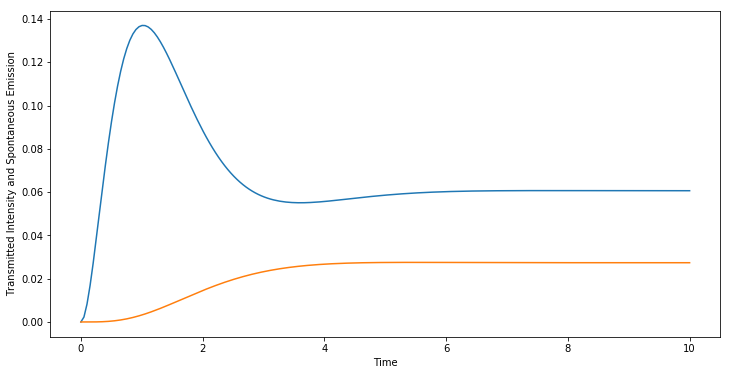

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(count1))
ax.plot(tlist, np.real(count2))
ax.set_xlabel('Time')
ax.set_ylabel('Transmitted Intensity and Spontaneous Emission');

Alternatively

In [9]:
def solve_solver(E,kappa,gamma,g,wc,w0,wl,N,tlist):

    ida    = qeye(N)
    idatom = qeye(2)

    # Define cavity field and atomic operators
    a  = tensor(destroy(N),idatom)
    sm = tensor(ida,sigmam())

    # Hamiltonian
    H = (w0-wl)*sm.dag()*sm + (wc-wl)*a.dag()*a + 1j*g*(a.dag()*sm - sm.dag()*a) \
        + E*(a.dag()+a)

    #collapse operators
    C1 = np.sqrt(2*kappa)*a
    C2 = np.sqrt(gamma)*sm
    C1dC1 = C1.dag()*C1
    C2dC2 = C2.dag()*C2

    #intial state
    psi0 = tensor(basis(N,0),basis(2,1))
    rho0 = psi0.dag() * psi0;

    # evolve and calculate expectation values
    solver = MeSolver(H, [C1, C2])
    output = solver.run(psi0, tlist, e_ops=[C1dC1, C2dC2, a])  

    return output.expect[0], output.expect[1], output.expect[2]

Text(0, 0.5, 'Transmitted Intensity and Spontaneous Emission')

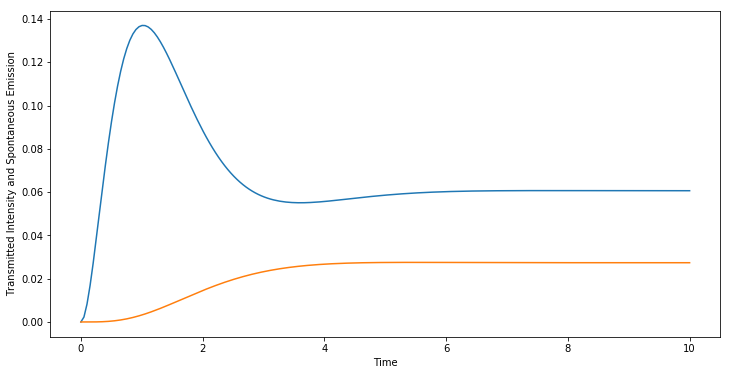

In [10]:
count1, count2, infield = solve_solver(E, kappa, gamma, g, wc, w0, wl, N, tlist)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(count1))
ax.plot(tlist, np.real(count2))
ax.set_xlabel('Time')
ax.set_ylabel('Transmitted Intensity and Spontaneous Emission')

### eseries

In [11]:
def solve(E,kappa,gamma,g,wc,w0,wl,N,tlist):

    # Define cavity field and atomic operators
    a  = tensor(destroy(N),qeye(2))
    sm = tensor(qeye(N),sigmam())

    # Hamiltonian
    H = (w0-wl)*sm.dag()*sm + (wc-wl)*a.dag()*a + 1j*g*(a.dag()*sm - sm.dag()*a) \
        + E*(a.dag()+a)

    #collapse operators
    C1 = np.sqrt(2*kappa)*a
    C2 = np.sqrt(gamma)*sm
    C1dC1 = C1.dag() * C1
    C2dC2 = C2.dag() * C2

    #intial state
    psi0 = tensor(basis(N,0),basis(2,1))
    rho0 = ket2dm(psi0)

    # Calculate the Liouvillian
    L = liouvillian(H, [C1, C2])

    # Calculate solution as an exponential series
    rhoES = ode2es(L,rho0);
    
    # Calculate expectation values
    count1  = esval(expect(C1dC1,rhoES),tlist);
    count2  = esval(expect(C2dC2,rhoES),tlist);
    infield = esval(expect(a,rhoES),tlist);

    # alternative
    expt_list = essolve(H, psi0, tlist, [C1, C2], [C1dC1, C2dC2, a]).expect

    return count1, count2, infield, expt_list[0], expt_list[1], expt_list[2]

In [12]:
count1, count2, infield, count1_2, count2_2, infield_2 = solve(E, kappa, gamma, g, wc, w0, wl, N, tlist)

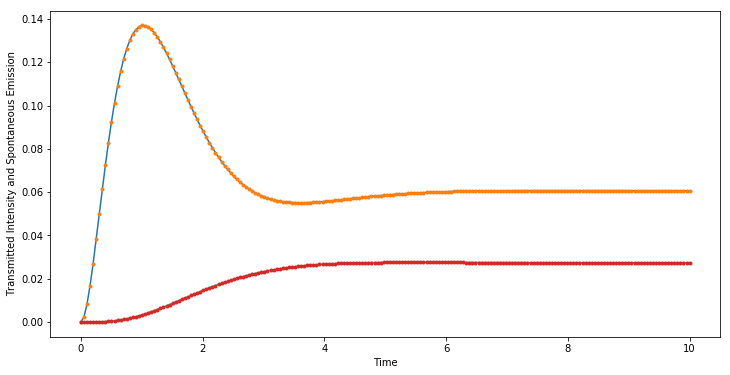

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tlist, np.real(count1), tlist, np.real(count1_2), '.')
ax.plot(tlist, np.real(count2), tlist, np.real(count2_2), '.')
ax.set_xlabel('Time')
ax.set_ylabel('Transmitted Intensity and Spontaneous Emission');

### mcsolve

In [14]:
ntraj = 500 #number of Monte-Carlo trajectories
# Hamiltonian
ida = qeye(N)
idatom = qeye(2)
a = tensor(destroy(N),idatom)
sm = tensor(ida,sigmam())
H = (w0-wl)*sm.dag()*sm + (wc-wl)*a.dag()*a + 1j*g*(a.dag()*sm-sm.dag()*a) + E*(a.dag()+a)
# collapse operators
C1 = np.sqrt(2*kappa) * a
C2 = np.sqrt(gamma) * sm
C1dC1 = C1.dag() * C1
C2dC2 = C2.dag() * C2
# intial state
psi0=tensor(basis(N,0),basis(2,1))

In [15]:
avg = mcsolve(H, psi0, tlist, [C1,C2],[C1dC1,C2dC2], ntraj)

10.0%. Run time:   0.38s. Est. time left: 00:00:00:03
20.0%. Run time:   0.70s. Est. time left: 00:00:00:02
30.0%. Run time:   1.02s. Est. time left: 00:00:00:02
40.0%. Run time:   1.35s. Est. time left: 00:00:00:02
50.0%. Run time:   1.69s. Est. time left: 00:00:00:01
60.0%. Run time:   2.08s. Est. time left: 00:00:00:01
70.0%. Run time:   2.43s. Est. time left: 00:00:00:01
80.0%. Run time:   2.79s. Est. time left: 00:00:00:00
90.0%. Run time:   3.09s. Est. time left: 00:00:00:00
100.0%. Run time:   3.44s. Est. time left: 00:00:00:00
Total run time:   3.45s


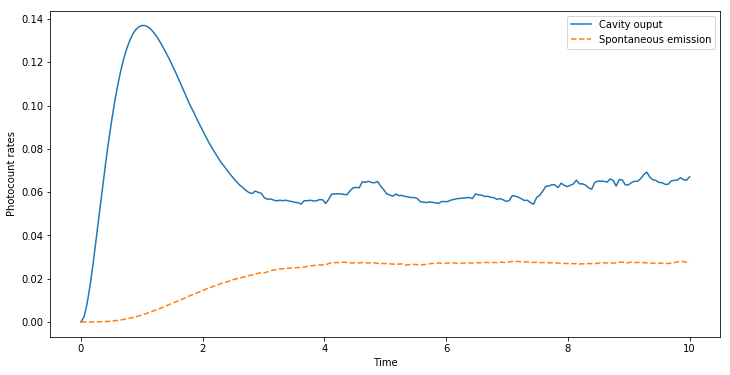

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tlist, avg.expect[0],
        tlist, avg.expect[1],'--')
ax.set_xlabel('Time')
ax.set_ylabel('Photocount rates')
ax.legend(('Cavity ouput', 'Spontaneous emission'));

## Versions

In [ ]:
from qutip.ipynbtools import version_table

version_table()